In [1]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
from preprocessing import *
from model import *
import math
import matplotlib.pyplot as plt
seed = 42

# to autoreload modules on code change
%load_ext autoreload
%autoreload 2

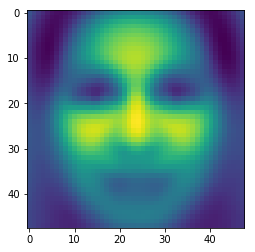

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = get_emotion_data()
# Displays average image

In [3]:
y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)
y_test = y_test.reshape(-1)

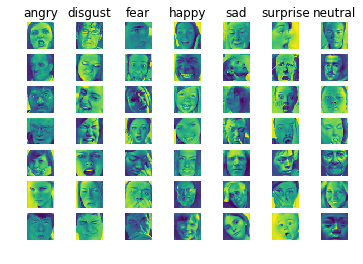

In [4]:
classes = ['angry','disgust','fear','happy','sad','surprise','neutral']
num_classes = len(classes)
samples_per_class = 7
for y,cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(48,48)) #pixel height and width
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss * actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
#             print(accuracy.eval())
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if not training_now:
            print()
            break
        print('\nValidation')
        run_model(session,y_out,mean_loss,X_val,y_val,1,64)
        if plot_losses:
#             print(losses[-1],losses[-2])
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

# This function print loss in the end
# def run_model(session, predict, loss_val, Xd, yd,
#               epochs=1, batch_size=64, print_every=100,
#               training=None, plot_losses=False):
#     # have tensorflow compute accuracy
#     correct_prediction = tf.equal(tf.argmax(predict,1), y)
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
#     # shuffle indicies
# #     tf.set_random_seed(seed)
#     np.random.seed(seed)
#     train_indicies = np.arange(Xd.shape[0])
#     np.random.shuffle(train_indicies)

#     training_now = training is not None
    
#     # setting up variables we want to compute (and optimizing)
#     # if we have a training function, add that to things we compute
#     variables = [mean_loss,correct_prediction,accuracy]
#     if training_now:
#         variables[-1] = training
    
#     # counter 
#     iter_cnt = 0
#     losses = []
#     for e in range(epochs):
#         # keep track of losses and accuracy
#         correct = 0
#         # make sure we iterate over the dataset once
#         for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
#             # generate indicies for the batch
#             start_idx = (i*batch_size)%Xd.shape[0]
#             idx = train_indicies[start_idx:start_idx+batch_size]
            
#             # create a feed dictionary for this batch
#             feed_dict = {X: Xd[idx,:],
#                          y: yd[idx],
#                          is_training: training_now }
#             # get batch size
#             actual_batch_size = yd[idx].shape[0]
            
#             # have tensorflow compute loss and correct predictions
#             # and (if given) perform a training step
#             loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
#             # aggregate performance stats
#             losses.append(loss * actual_batch_size)
#             correct += np.sum(corr)
            
#             # print every now and then
# #             print(accuracy.eval())
#             if training_now and (iter_cnt % print_every) == 0:
#                 print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
#                       .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
#             iter_cnt += 1
#         total_correct = correct/Xd.shape[0]
#         total_loss = np.sum(losses)/Xd.shape[0]
#         print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
#               .format(total_loss,total_correct,e+1))
#         if not training_now:
#             print()
#             break
#         print('\nValidation')
#         run_model(session,y_out,mean_loss,X_val,y_val,1,64)
#     if plot_losses:
#         plt.plot(losses)
#         plt.grid(True)
#         plt.title('Epoch {} Loss'.format(e+1))
#         plt.xlabel('minibatch number')
#         plt.ylabel('minibatch loss')
#         plt.show()
#     return total_loss,total_correct

# model1
A simple 3 layered feed forward neural net with 100 units in each hidden layer with xaviers initialisation

Training
Iteration 0: with minibatch training loss = 49.7 and accuracy of 0.25
Iteration 100: with minibatch training loss = 9.73 and accuracy of 0.094
Iteration 200: with minibatch training loss = 1.97 and accuracy of 0.31
Iteration 300: with minibatch training loss = 1.84 and accuracy of 0.2
Iteration 400: with minibatch training loss = 1.77 and accuracy of 0.3
Epoch 1, Overall loss = 19.5 and accuracy of 0.232

Validation
Epoch 1, Overall loss = 1.85 and accuracy of 0.248

68.3746874332 132.79838562


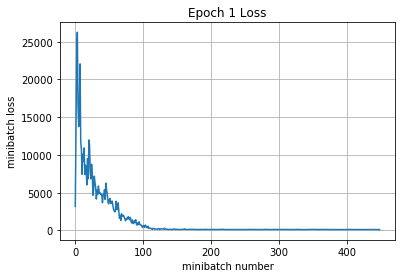

Iteration 500: with minibatch training loss = 1.75 and accuracy of 0.31
Iteration 600: with minibatch training loss = 1.9 and accuracy of 0.19
Iteration 700: with minibatch training loss = 1.76 and accuracy of 0.28
Iteration 800: with minibatch training loss = 1.84 and accuracy of 0.34
Epoch 2, Overall loss = 1.81 and accuracy of 0.253

Validation
Epoch 1, Overall loss = 1.84 and accuracy of 0.249

68.3288862705 113.102478027


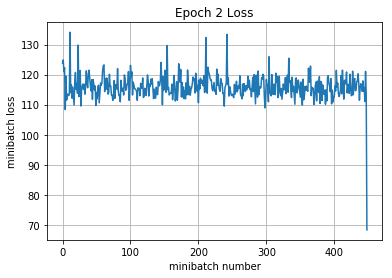

Iteration 900: with minibatch training loss = 1.91 and accuracy of 0.19
Iteration 1000: with minibatch training loss = 1.9 and accuracy of 0.27
Iteration 1100: with minibatch training loss = 1.79 and accuracy of 0.22
Iteration 1200: with minibatch training loss = 1.81 and accuracy of 0.25
Iteration 1300: with minibatch training loss = 1.78 and accuracy of 0.22
Epoch 3, Overall loss = 1.81 and accuracy of 0.254

Validation
Epoch 1, Overall loss = 1.84 and accuracy of 0.249

68.3822562695 112.934234619


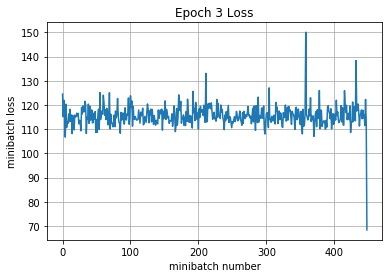

Iteration 1400: with minibatch training loss = 1.85 and accuracy of 0.27
Iteration 1500: with minibatch training loss = 1.79 and accuracy of 0.3
Iteration 1600: with minibatch training loss = 1.8 and accuracy of 0.22
Iteration 1700: with minibatch training loss = 1.72 and accuracy of 0.34
Epoch 4, Overall loss = 1.81 and accuracy of 0.254

Validation
Epoch 1, Overall loss = 1.83 and accuracy of 0.251

68.3948665857 112.89201355


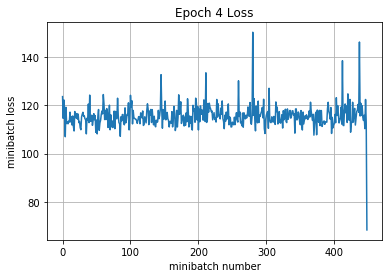

Iteration 1800: with minibatch training loss = 1.66 and accuracy of 0.38
Iteration 1900: with minibatch training loss = 1.84 and accuracy of 0.22
Iteration 2000: with minibatch training loss = 1.81 and accuracy of 0.25
Iteration 2100: with minibatch training loss = 2.16 and accuracy of 0.2
Iteration 2200: with minibatch training loss = 1.83 and accuracy of 0.23
Epoch 5, Overall loss = 1.81 and accuracy of 0.254

Validation
Epoch 1, Overall loss = 1.84 and accuracy of 0.25

68.4162807465 112.871994019


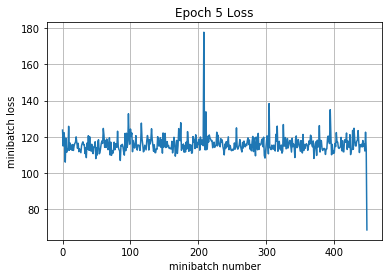

Iteration 2300: with minibatch training loss = 1.76 and accuracy of 0.28
Iteration 2400: with minibatch training loss = 1.78 and accuracy of 0.25
Iteration 2500: with minibatch training loss = 1.8 and accuracy of 0.31
Iteration 2600: with minibatch training loss = 1.73 and accuracy of 0.28
Epoch 6, Overall loss = 1.81 and accuracy of 0.253

Validation
Epoch 1, Overall loss = 1.84 and accuracy of 0.249

68.4231482744 112.862129211


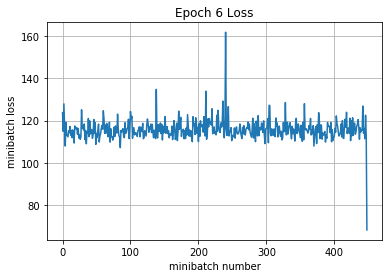

Iteration 2700: with minibatch training loss = 1.77 and accuracy of 0.27
Iteration 2800: with minibatch training loss = 1.75 and accuracy of 0.23
Iteration 2900: with minibatch training loss = 1.84 and accuracy of 0.2
Iteration 3000: with minibatch training loss = 1.8 and accuracy of 0.25
Iteration 3100: with minibatch training loss = 1.78 and accuracy of 0.3
Epoch 7, Overall loss = 1.81 and accuracy of 0.253

Validation
Epoch 1, Overall loss = 1.82 and accuracy of 0.249

68.4179391861 112.872543335


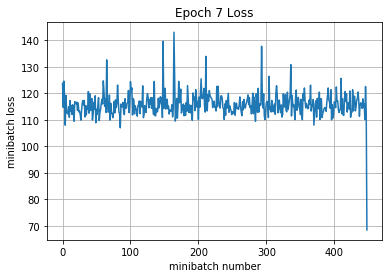

Iteration 3200: with minibatch training loss = 1.82 and accuracy of 0.25
Iteration 3300: with minibatch training loss = 1.76 and accuracy of 0.27
Iteration 3400: with minibatch training loss = 1.78 and accuracy of 0.27
Iteration 3500: with minibatch training loss = 1.82 and accuracy of 0.23
Epoch 8, Overall loss = 1.81 and accuracy of 0.253

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.25

68.4204180241 112.868003845


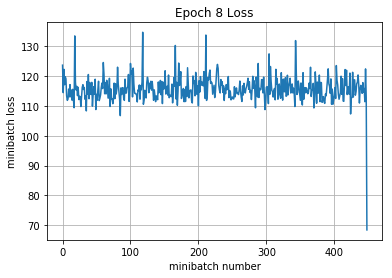

Iteration 3600: with minibatch training loss = 1.76 and accuracy of 0.27
Iteration 3700: with minibatch training loss = 1.78 and accuracy of 0.3
Iteration 3800: with minibatch training loss = 1.9 and accuracy of 0.2
Iteration 3900: with minibatch training loss = 1.83 and accuracy of 0.2
Iteration 4000: with minibatch training loss = 1.77 and accuracy of 0.3
Epoch 9, Overall loss = 1.81 and accuracy of 0.252

Validation
Epoch 1, Overall loss = 1.82 and accuracy of 0.25

68.4090647697 112.88369751


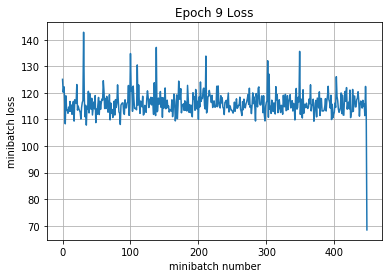

Iteration 4100: with minibatch training loss = 1.83 and accuracy of 0.22
Iteration 4200: with minibatch training loss = 1.77 and accuracy of 0.25
Iteration 4300: with minibatch training loss = 1.8 and accuracy of 0.16
Iteration 4400: with minibatch training loss = 1.81 and accuracy of 0.22
Epoch 10, Overall loss = 1.81 and accuracy of 0.252

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.25

68.4045393467 112.885368347


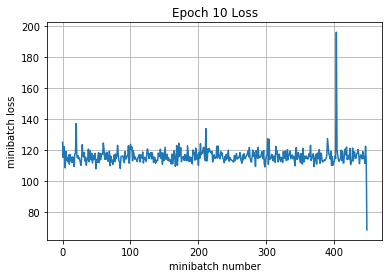

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.25



In [19]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
global_step = tf.Variable(0,trainable=False) # to decay learning rate!!
learning_rate = tf.train.exponential_decay(5e-3,global_step=global_step,decay_steps=1000,decay_rate=0.95)
y_out = model1(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(total_loss,global_step=global_step)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

# model2 
a bigger model
5000,1000,100,100,7 units in respective layers with xaviers initialisation

Training
Iteration 0: with minibatch training loss = 25.9 and accuracy of 0.16
Iteration 100: with minibatch training loss = 1.91 and accuracy of 0.2
Iteration 200: with minibatch training loss = 1.72 and accuracy of 0.33
Iteration 300: with minibatch training loss = 1.81 and accuracy of 0.2
Iteration 400: with minibatch training loss = 1.76 and accuracy of 0.3
Epoch 1, Overall loss = 235 and accuracy of 0.241

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.249

68.9561822414 112.804779053


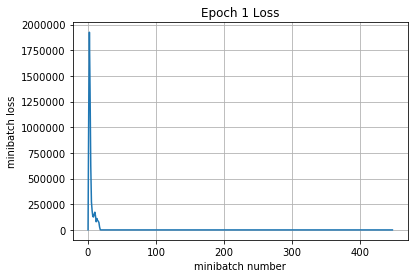

Iteration 500: with minibatch training loss = 1.75 and accuracy of 0.3
Iteration 600: with minibatch training loss = 1.91 and accuracy of 0.19
Iteration 700: with minibatch training loss = 1.76 and accuracy of 0.28
Iteration 800: with minibatch training loss = 1.85 and accuracy of 0.34
Epoch 2, Overall loss = 1.81 and accuracy of 0.251

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.249

68.9475195408 112.812591553


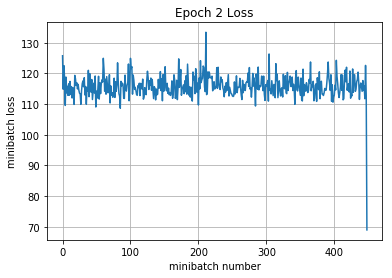

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.249



In [21]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
# global_step = tf.Variable(0,trainable=False) # to decay learning rate!!
# learning_rate = tf.train.exponential_decay(1e-1,global_step=global_step,decay_steps=10000,decay_rate=0.97)
y_out = model2(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
train_step = optimizer.minimize(total_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,2,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

# model3
tried reducing the umber of layers to see effect on accuracy
5000,300,100,7

Training
Iteration 0: with minibatch training loss = 44.8 and accuracy of 0.14
Iteration 100: with minibatch training loss = 26.7 and accuracy of 0.23
Iteration 200: with minibatch training loss = 8.12 and accuracy of 0.25
Iteration 300: with minibatch training loss = 5.78 and accuracy of 0.19
Iteration 400: with minibatch training loss = 2.94 and accuracy of 0.38
Epoch 1, Overall loss = 21.8 and accuracy of 0.258

Validation
Epoch 1, Overall loss = 2.79 and accuracy of 0.296



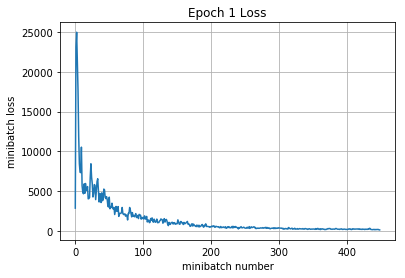

Iteration 500: with minibatch training loss = 2.27 and accuracy of 0.34
Iteration 600: with minibatch training loss = 1.82 and accuracy of 0.39
Iteration 700: with minibatch training loss = 2.11 and accuracy of 0.34
Iteration 800: with minibatch training loss = 1.67 and accuracy of 0.42
Epoch 2, Overall loss = 2.03 and accuracy of 0.353

Validation
Epoch 1, Overall loss = 2.1 and accuracy of 0.305



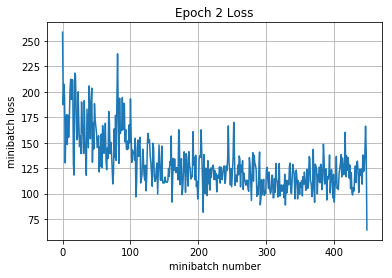

Validation
Epoch 1, Overall loss = 2.1 and accuracy of 0.305



In [28]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model3(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
train_step = optimizer.minimize(total_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,2,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

** In the above model even training on only 1000 examples for 10 epochs we got an accuracy of ~23 % which is almost equal to training on full dataset for one epoch **

# model 4
model3 with batch norm

Training
Iteration 0: with minibatch training loss = 2.1 and accuracy of 0.14
Iteration 100: with minibatch training loss = 1.86 and accuracy of 0.25
Iteration 200: with minibatch training loss = 1.63 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.75 and accuracy of 0.23
Iteration 400: with minibatch training loss = 1.53 and accuracy of 0.39
Epoch 1, Overall loss = 1.68 and accuracy of 0.329

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.371



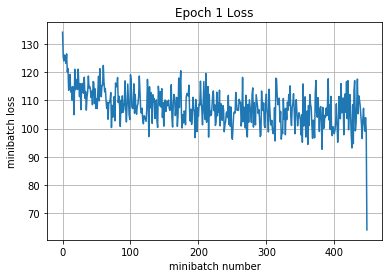

Iteration 500: with minibatch training loss = 1.52 and accuracy of 0.44
Iteration 600: with minibatch training loss = 1.66 and accuracy of 0.39
Iteration 700: with minibatch training loss = 1.46 and accuracy of 0.45
Iteration 800: with minibatch training loss = 1.53 and accuracy of 0.42
Epoch 2, Overall loss = 1.6 and accuracy of 0.373

Validation
Epoch 1, Overall loss = 1.59 and accuracy of 0.381



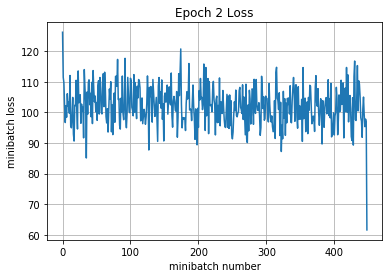

Validation
Epoch 1, Overall loss = 1.59 and accuracy of 0.381



In [12]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model4(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=5e-3)

# BN in tensorflow requires this extra dependency according to CS231n
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
# train_step = optimizer.minimize(total_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,2,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

# model5
trying using batchnormalisation on the input as well. Conclusion - no significant improvement! :(

Training
Iteration 0: with minibatch training loss = 2.09 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.82 and accuracy of 0.28
Iteration 200: with minibatch training loss = 1.63 and accuracy of 0.33
Iteration 300: with minibatch training loss = 1.71 and accuracy of 0.23
Iteration 400: with minibatch training loss = 1.52 and accuracy of 0.36
Epoch 1, Overall loss = 1.68 and accuracy of 0.332

Validation
Epoch 1, Overall loss = 1.63 and accuracy of 0.363



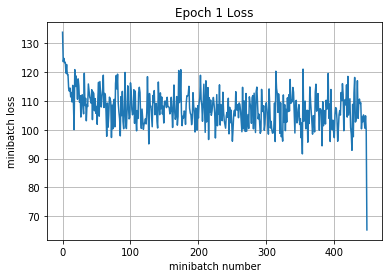

Iteration 500: with minibatch training loss = 1.55 and accuracy of 0.39
Iteration 600: with minibatch training loss = 1.67 and accuracy of 0.33
Iteration 700: with minibatch training loss = 1.49 and accuracy of 0.5
Iteration 800: with minibatch training loss = 1.52 and accuracy of 0.41
Epoch 2, Overall loss = 1.62 and accuracy of 0.358

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.366



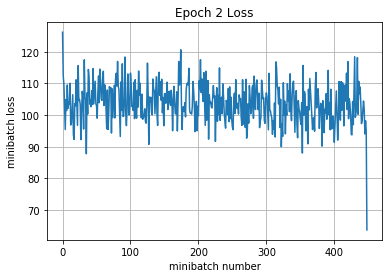

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.366



In [21]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model5(X,y,seed)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=7e-3)

# BN in tensorflow requires this extra dependency according to CS231n
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,2,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Model 6
2 conv layer Convnet :D

Training
Iteration 0: with minibatch training loss = 33 and accuracy of 0.047
Iteration 100: with minibatch training loss = 2.02 and accuracy of 0.25
Iteration 200: with minibatch training loss = 2.04 and accuracy of 0.17
Iteration 300: with minibatch training loss = 1.79 and accuracy of 0.33
Iteration 400: with minibatch training loss = 1.61 and accuracy of 0.41
Epoch 1, Overall loss = 3.35 and accuracy of 0.279

Validation
Epoch 1, Overall loss = 1.62 and accuracy of 0.366



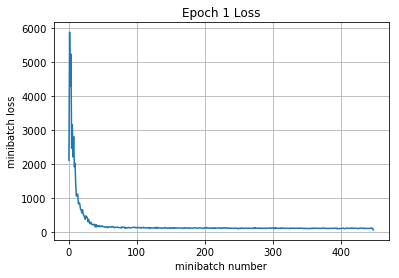

Iteration 500: with minibatch training loss = 1.48 and accuracy of 0.39
Iteration 600: with minibatch training loss = 1.63 and accuracy of 0.42
Iteration 700: with minibatch training loss = 1.41 and accuracy of 0.5
Iteration 800: with minibatch training loss = 1.42 and accuracy of 0.5
Epoch 2, Overall loss = 1.53 and accuracy of 0.412

Validation
Epoch 1, Overall loss = 1.54 and accuracy of 0.402



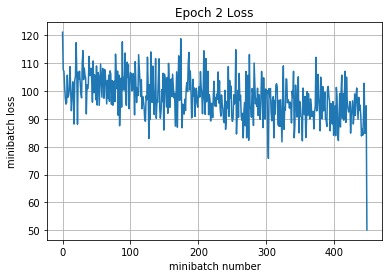

Iteration 900: with minibatch training loss = 1.36 and accuracy of 0.52
Iteration 1000: with minibatch training loss = 1.29 and accuracy of 0.53
Iteration 1100: with minibatch training loss = 1.26 and accuracy of 0.56
Iteration 1200: with minibatch training loss = 0.97 and accuracy of 0.62
Iteration 1300: with minibatch training loss = 1.18 and accuracy of 0.55
Epoch 3, Overall loss = 1.29 and accuracy of 0.518

Validation
Epoch 1, Overall loss = 1.54 and accuracy of 0.424



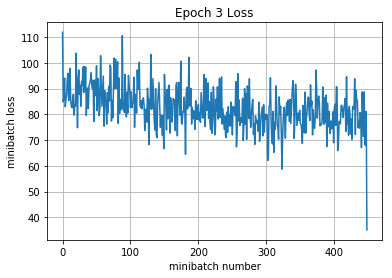

Iteration 1400: with minibatch training loss = 1.17 and accuracy of 0.58
Iteration 1500: with minibatch training loss = 0.827 and accuracy of 0.73
Iteration 1600: with minibatch training loss = 0.985 and accuracy of 0.64
Iteration 1700: with minibatch training loss = 0.909 and accuracy of 0.7
Epoch 4, Overall loss = 1.05 and accuracy of 0.617

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.425



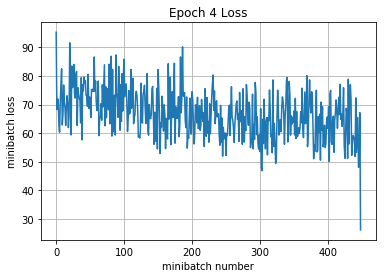

Iteration 1800: with minibatch training loss = 0.783 and accuracy of 0.7
Iteration 1900: with minibatch training loss = 0.839 and accuracy of 0.69
Iteration 2000: with minibatch training loss = 0.806 and accuracy of 0.67
Iteration 2100: with minibatch training loss = 0.668 and accuracy of 0.75
Iteration 2200: with minibatch training loss = 0.816 and accuracy of 0.75
Epoch 5, Overall loss = 0.823 and accuracy of 0.702

Validation
Epoch 1, Overall loss = 1.69 and accuracy of 0.434



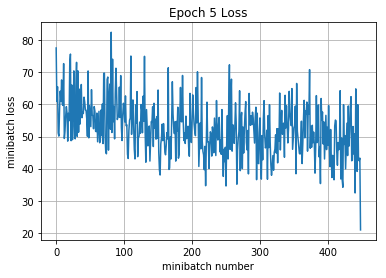

Iteration 2300: with minibatch training loss = 0.75 and accuracy of 0.75
Iteration 2400: with minibatch training loss = 0.578 and accuracy of 0.77
Iteration 2500: with minibatch training loss = 0.766 and accuracy of 0.73
Iteration 2600: with minibatch training loss = 0.672 and accuracy of 0.73
Epoch 6, Overall loss = 0.647 and accuracy of 0.771

Validation
Epoch 1, Overall loss = 1.85 and accuracy of 0.433



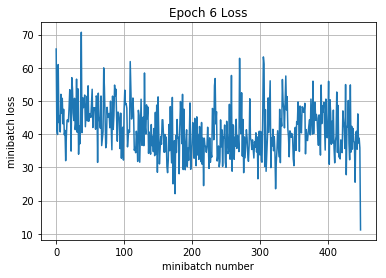

Iteration 2700: with minibatch training loss = 0.579 and accuracy of 0.84
Iteration 2800: with minibatch training loss = 0.447 and accuracy of 0.86
Iteration 2900: with minibatch training loss = 0.537 and accuracy of 0.78
Iteration 3000: with minibatch training loss = 0.486 and accuracy of 0.78
Iteration 3100: with minibatch training loss = 0.333 and accuracy of 0.92
Epoch 7, Overall loss = 0.535 and accuracy of 0.816

Validation
Epoch 1, Overall loss = 2.02 and accuracy of 0.44



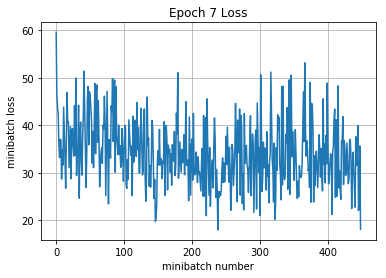

Iteration 3200: with minibatch training loss = 0.665 and accuracy of 0.75
Iteration 3300: with minibatch training loss = 0.404 and accuracy of 0.86
Iteration 3400: with minibatch training loss = 0.351 and accuracy of 0.88
Iteration 3500: with minibatch training loss = 0.4 and accuracy of 0.91
Epoch 8, Overall loss = 0.464 and accuracy of 0.839

Validation
Epoch 1, Overall loss = 2.1 and accuracy of 0.444



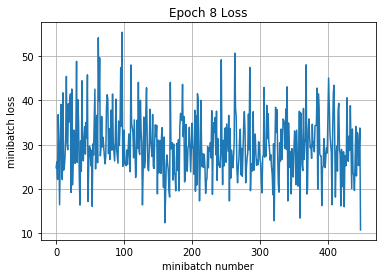

Iteration 3600: with minibatch training loss = 0.445 and accuracy of 0.89
Iteration 3700: with minibatch training loss = 0.363 and accuracy of 0.84
Iteration 3800: with minibatch training loss = 0.266 and accuracy of 0.91
Iteration 3900: with minibatch training loss = 0.342 and accuracy of 0.91
Iteration 4000: with minibatch training loss = 0.284 and accuracy of 0.89
Epoch 9, Overall loss = 0.422 and accuracy of 0.857

Validation
Epoch 1, Overall loss = 2.15 and accuracy of 0.448



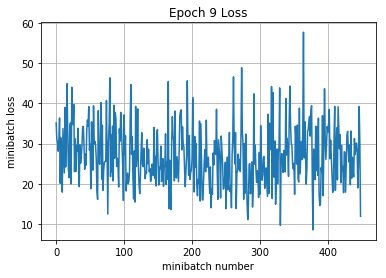

Iteration 4100: with minibatch training loss = 0.304 and accuracy of 0.88
Iteration 4200: with minibatch training loss = 0.34 and accuracy of 0.86
Iteration 4300: with minibatch training loss = 0.403 and accuracy of 0.8
Iteration 4400: with minibatch training loss = 0.246 and accuracy of 0.92
Epoch 10, Overall loss = 0.374 and accuracy of 0.873

Validation
Epoch 1, Overall loss = 2.35 and accuracy of 0.437



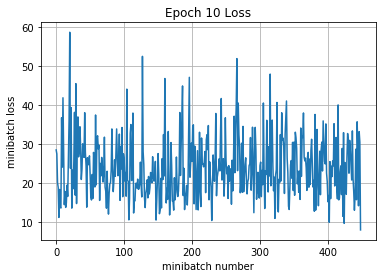

Validation
Epoch 1, Overall loss = 2.35 and accuracy of 0.437



In [30]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model6(X,y,seed=seed,is_training=is_training)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
train_step = optimizer.minimize(mean_loss)

# # BN in tensorflow requires this extra dependency according to CS231n
# extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(extra_update_ops):
#     train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Model 7
convnet with batchnorm!

Training
Iteration 0: with minibatch training loss = 3.18 and accuracy of 0.16
Iteration 100: with minibatch training loss = 2.3 and accuracy of 0.36
Iteration 200: with minibatch training loss = 1.91 and accuracy of 0.36
Iteration 300: with minibatch training loss = 1.76 and accuracy of 0.33
Iteration 400: with minibatch training loss = 1.45 and accuracy of 0.41
Epoch 1, Overall loss = 1.91 and accuracy of 0.366

Validation
Epoch 1, Overall loss = 1.49 and accuracy of 0.445



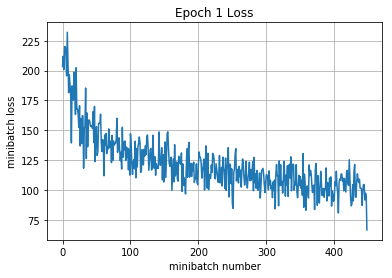

Iteration 500: with minibatch training loss = 1.3 and accuracy of 0.44
Iteration 600: with minibatch training loss = 1.37 and accuracy of 0.5
Iteration 700: with minibatch training loss = 1.34 and accuracy of 0.52
Iteration 800: with minibatch training loss = 1.39 and accuracy of 0.52
Epoch 2, Overall loss = 1.43 and accuracy of 0.466

Validation
Epoch 1, Overall loss = 1.4 and accuracy of 0.473



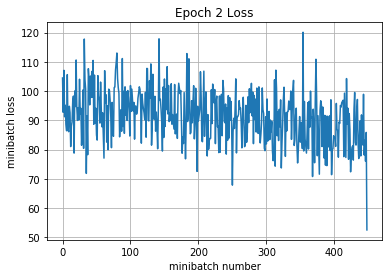

Iteration 900: with minibatch training loss = 1.38 and accuracy of 0.39
Iteration 1000: with minibatch training loss = 1.34 and accuracy of 0.5
Iteration 1100: with minibatch training loss = 1.41 and accuracy of 0.5
Iteration 1200: with minibatch training loss = 1.2 and accuracy of 0.53
Iteration 1300: with minibatch training loss = 1.14 and accuracy of 0.59
Epoch 3, Overall loss = 1.28 and accuracy of 0.52

Validation
Epoch 1, Overall loss = 1.37 and accuracy of 0.49



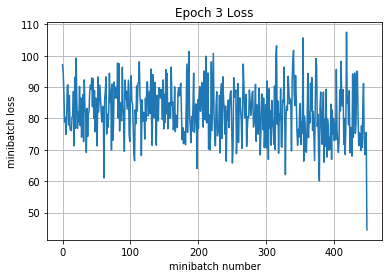

Iteration 1400: with minibatch training loss = 1.15 and accuracy of 0.56
Iteration 1500: with minibatch training loss = 1.35 and accuracy of 0.52
Iteration 1600: with minibatch training loss = 1.1 and accuracy of 0.64
Iteration 1700: with minibatch training loss = 1.16 and accuracy of 0.52
Epoch 4, Overall loss = 1.17 and accuracy of 0.567

Validation
Epoch 1, Overall loss = 1.38 and accuracy of 0.497



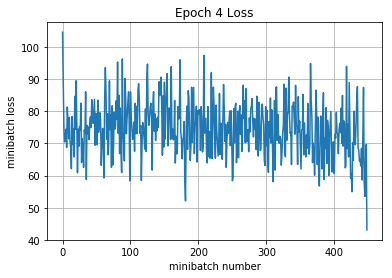

Iteration 1800: with minibatch training loss = 1.11 and accuracy of 0.58
Iteration 1900: with minibatch training loss = 0.978 and accuracy of 0.62
Iteration 2000: with minibatch training loss = 1.26 and accuracy of 0.48
Iteration 2100: with minibatch training loss = 1.07 and accuracy of 0.62
Iteration 2200: with minibatch training loss = 0.996 and accuracy of 0.66
Epoch 5, Overall loss = 1.05 and accuracy of 0.612

Validation
Epoch 1, Overall loss = 1.41 and accuracy of 0.491



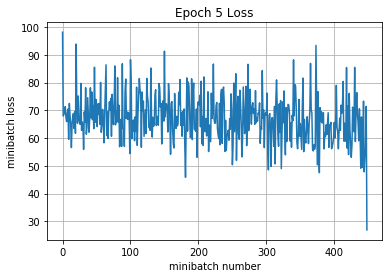

Iteration 2300: with minibatch training loss = 0.924 and accuracy of 0.61
Iteration 2400: with minibatch training loss = 0.748 and accuracy of 0.73
Iteration 2500: with minibatch training loss = 1.1 and accuracy of 0.64
Iteration 2600: with minibatch training loss = 0.741 and accuracy of 0.77
Epoch 6, Overall loss = 0.919 and accuracy of 0.658

Validation
Epoch 1, Overall loss = 1.42 and accuracy of 0.502



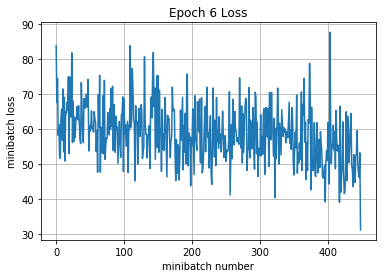

Iteration 2700: with minibatch training loss = 0.767 and accuracy of 0.7
Iteration 2800: with minibatch training loss = 0.712 and accuracy of 0.72
Iteration 2900: with minibatch training loss = 0.71 and accuracy of 0.75
Iteration 3000: with minibatch training loss = 0.886 and accuracy of 0.69
Iteration 3100: with minibatch training loss = 0.619 and accuracy of 0.78
Epoch 7, Overall loss = 0.794 and accuracy of 0.709

Validation
Epoch 1, Overall loss = 1.52 and accuracy of 0.499



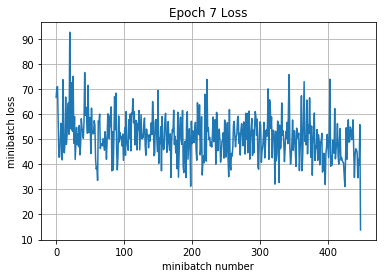

Iteration 3200: with minibatch training loss = 0.638 and accuracy of 0.8
Iteration 3300: with minibatch training loss = 0.831 and accuracy of 0.67
Iteration 3400: with minibatch training loss = 0.716 and accuracy of 0.77
Iteration 3500: with minibatch training loss = 0.574 and accuracy of 0.8
Epoch 8, Overall loss = 0.685 and accuracy of 0.751

Validation
Epoch 1, Overall loss = 1.54 and accuracy of 0.514



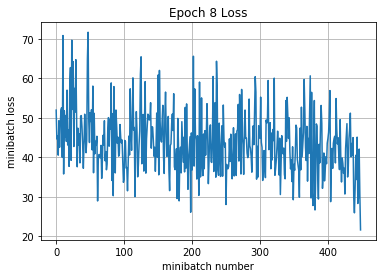

Iteration 3600: with minibatch training loss = 0.721 and accuracy of 0.66
Iteration 3700: with minibatch training loss = 0.552 and accuracy of 0.86
Iteration 3800: with minibatch training loss = 0.477 and accuracy of 0.8
Iteration 3900: with minibatch training loss = 0.561 and accuracy of 0.78
Iteration 4000: with minibatch training loss = 0.593 and accuracy of 0.81
Epoch 9, Overall loss = 0.579 and accuracy of 0.79

Validation
Epoch 1, Overall loss = 1.63 and accuracy of 0.516



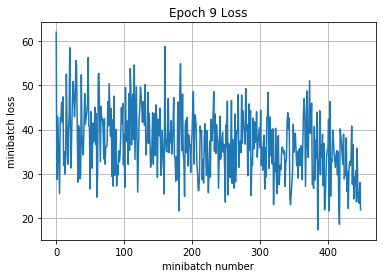

Iteration 4100: with minibatch training loss = 0.417 and accuracy of 0.88
Iteration 4200: with minibatch training loss = 0.403 and accuracy of 0.84
Iteration 4300: with minibatch training loss = 0.504 and accuracy of 0.86
Iteration 4400: with minibatch training loss = 0.383 and accuracy of 0.88
Epoch 10, Overall loss = 0.505 and accuracy of 0.818

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.518



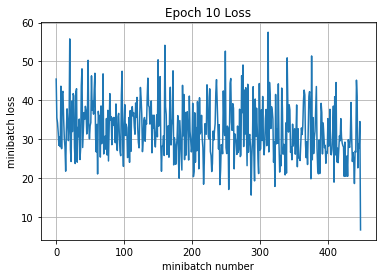

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.518



In [34]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=[None,2304],name='X')
y = tf.placeholder(tf.int64,shape=[None],name='y')
is_training = tf.placeholder(tf.bool)
y_out = model7(X,y,seed=seed,is_training=is_training)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,7),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
# train_step = optimizer.minimize(mean_loss)

# # BN in tensorflow requires this extra dependency according to CS231n
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)